# Proyecto Final
## Análisis de Sentimientos en Opiniones de Pasajeros de una Aerolínea con NLP y PySpark en un entorno Big Data

In [40]:

# Importar librerías necesarias
import plotly.express as px
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, when, avg, trim
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.ml.stat import Summarizer 
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
# Descargar recursos necesarios de NLTK
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#Descargar recursos para ML
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
from scipy import stats

# Crear la sesión de Spark
spark = SparkSession.builder

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Crear la sesión de Spark
spark = SparkSession.builder \
    .appName("SentimentAnalysis") \
    .getOrCreate()

### Recolectar datos

In [4]:

import opendatasets as od  
 
od.download(
    "https://www.kaggle.com/datasets/cristaliss/ryanair-reviews-ratings", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/cristaliss/ryanair-reviews-ratings


100%|██████████| 630k/630k [00:00<00:00, 2.13MB/s]

In [5]:
import os

# Listar archivos en el directorio de descarga
download_dir = './ryanair-reviews-ratings'
files = os.listdir(download_dir)
print(files)


['ryanair_reviews.csv']


In [6]:
# Ruta al archivo CSV
csv_file_path = './ryanair-reviews-ratings/ryanair_reviews.csv'

# Leer el archivo CSV en un DataFrame de Spark
data = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Mostrar las primeras filas del DataFrame
data.show()

+---+--------------+--------------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------+---------------+-----------+----------------------+-------------------+
|_c0|Date Published|Overall Rating|Passenger Country|Trip_verified|       Comment title|             Comment|            Aircraft|   Type Of Traveller|           Seat Type|              Origin|         Destination|       Date Flown|        Seat Comfort| Cabin Staff Service|    Food & Beverages|Ground Service|Value For Money|Recommended|Inflight Entertainment|Wifi & Connectivity|
+---+--------------+--------------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+----

In [7]:
data.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Date Published: string (nullable = true)
 |-- Overall Rating: string (nullable = true)
 |-- Passenger Country: string (nullable = true)
 |-- Trip_verified: string (nullable = true)
 |-- Comment title: string (nullable = true)
 |-- Comment: string (nullable = true)
 |-- Aircraft: string (nullable = true)
 |-- Type Of Traveller: string (nullable = true)
 |-- Seat Type: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Date Flown: string (nullable = true)
 |-- Seat Comfort: string (nullable = true)
 |-- Cabin Staff Service: string (nullable = true)
 |-- Food & Beverages: string (nullable = true)
 |-- Ground Service: string (nullable = true)
 |-- Value For Money: string (nullable = true)
 |-- Recommended: string (nullable = true)
 |-- Inflight Entertainment: string (nullable = true)
 |-- Wifi & Connectivity: string (nullable = true)



In [8]:
df=data.toPandas()

In [9]:
df.columns

Index(['_c0', 'Date Published', 'Overall Rating', 'Passenger Country',
       'Trip_verified', 'Comment title', 'Comment', 'Aircraft',
       'Type Of Traveller', 'Seat Type', 'Origin', 'Destination', 'Date Flown',
       'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
       'Ground Service', 'Value For Money', 'Recommended',
       'Inflight Entertainment', 'Wifi & Connectivity'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   _c0                     2263 non-null   object
 1   Date Published          2259 non-null   object
 2   Overall Rating          2130 non-null   object
 3   Passenger Country       2258 non-null   object
 4   Trip_verified           1313 non-null   object
 5   Comment title           2260 non-null   object
 6   Comment                 2249 non-null   object
 7   Aircraft                676 non-null    object
 8   Type Of Traveller       1599 non-null   object
 9   Seat Type               2220 non-null   object
 10  Origin                  1621 non-null   object
 11  Destination             1615 non-null   object
 12  Date Flown              1617 non-null   object
 13  Seat Comfort            2140 non-null   object
 14  Cabin Staff Service     2129 non-null   object
 15  Food

In [11]:
df.isnull().sum()

_c0                          0
Date Published               4
Overall Rating             133
Passenger Country            5
Trip_verified              950
Comment title                3
Comment                     14
Aircraft                  1587
Type Of Traveller          664
Seat Type                   43
Origin                     642
Destination                648
Date Flown                 646
Seat Comfort               123
Cabin Staff Service        134
Food & Beverages           849
Ground Service             716
Value For Money             55
Recommended                 47
Inflight Entertainment    1825
Wifi & Connectivity       1909
dtype: int64

In [12]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2258    False
2259    False
2260    False
2261    False
2262    False
Length: 2263, dtype: bool

### Limpieza de datos

Eliminamos estas columnas del dataset porque contienen muchos nulos y no son relevantes para el proyecto

In [13]:
# Columnas a eliminar
columns_to_drop = ['_c0', 'Inflight Entertainment', 'Wifi & Connectivity', 'Aircraft']

# Eliminar las columnas no necesarias
data = data.drop(*columns_to_drop)

data.show()

+--------------+--------------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------+---------------+-----------+
|Date Published|Overall Rating|Passenger Country|Trip_verified|       Comment title|             Comment|   Type Of Traveller|           Seat Type|              Origin|         Destination|       Date Flown|        Seat Comfort| Cabin Staff Service|    Food & Beverages|Ground Service|Value For Money|Recommended|
+--------------+--------------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------+---------------+-----------+
|    2024-02-03|            10|   United Kingdom| Not Veri

#### Convertir columnas a tipo numérico

In [14]:
# Convertir las columnas a tipo numérico (int)
numeric_columns = ['Overall Rating', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Value For Money']
for column in numeric_columns:
    data = data.withColumn(column, col(column).cast('int'))



#### Eliminar valores nulos

In [15]:
# Eliminar filas con valores nulos en 'Comment'
data = data.dropna(subset=['Comment'])

# Eliminar fila con valor nulo en 'Date Published'
data = data.dropna(subset=['Date Published'])


#### Imputar valores nulos

In [16]:
# Imputar valores nulos en 'Overall Rating' con la mediana
median_overall_rating = data.approxQuantile("Overall Rating", [0.5], 0.25)[0]
data = data.withColumn('Overall Rating', when(col('Overall Rating').isNull(), median_overall_rating).otherwise(col('Overall Rating')))

# Reemplazar valores nulos en 'Passenger Country' con 'Unknown'
data = data.withColumn('Passenger Country', when(col('Passenger Country').isNull(), 'Unknown').otherwise(col('Passenger Country')))

# Imputar valores nulos en 'Trip_verified' con 'No'
data = data.withColumn('Trip_verified', when(col('Trip_verified').isNull(), 'No').otherwise(col('Trip_verified')))

# Reemplazar valores nulos en 'Comment title' con 'No Title'
data = data.withColumn('Comment title', when(col('Comment title').isNull(), 'No Title').otherwise(col('Comment title')))

# Imputar valores nulos en 'Type Of Traveller' con 'Unknown Traveller'
data = data.withColumn('Type Of Traveller', when(col('Type Of Traveller').isNull(), 'Unknown Traveller').otherwise(col('Type Of Traveller')))

# Imputar valores nulos en 'Seat Type' con 'Unknown Seat Type'
data = data.withColumn('Seat Type', when(col('Seat Type').isNull(), 'Unknown Seat Type').otherwise(col('Seat Type')))

# Reemplazar valores nulos en 'Origin' y 'Destination' con 'Unknown'
data = data.withColumn('Origin', when(col('Origin').isNull(), 'Unknown').otherwise(col('Origin')))
data = data.withColumn('Destination', when(col('Destination').isNull(), 'Unknown').otherwise(col('Destination')))

# Imputar valores nulos en 'Date Flown' con 'Unknown Date'
data = data.withColumn('Date Flown', when(col('Date Flown').isNull(), 'Unknown Date').otherwise(col('Date Flown')))


#### Imputar valores nulos en columnas de servicio

In [17]:
# Imputar valores nulos en columnas de servicio con la media
service_columns = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Value For Money']
for column in service_columns:
    mean_value = data.select(avg(col(column))).first()[0]
    data = data.withColumn(column, when(col(column).isNull(), mean_value).otherwise(col(column)))


#### Limpiar la columna 'Recommended'


In [18]:
# Limpiar la columna 'Recommended' para eliminar espacios en blanco
data = data.withColumn('Recommended', trim(col('Recommended')))

# Convertir la columna 'Recommended' de string a numérico (asegurarse de manejar bien los valores 'yes' y 'no')
data = data.withColumn('Recommended', when(col('Recommended') == 'yes', 1).when(col('Recommended') == 'no', 0).otherwise(col('Recommended')))

# Eliminar filas con valores nulos en 'Recommended' después de la limpieza
data = data.dropna(subset=['Recommended'])


In [19]:
# Mostrar el esquema del DataFrame después de la conversión
data.printSchema()

# Mostrar algunas filas para verificar la imputación y conversión
data.select(numeric_columns).show()

root
 |-- Date Published: string (nullable = true)
 |-- Overall Rating: double (nullable = true)
 |-- Passenger Country: string (nullable = true)
 |-- Trip_verified: string (nullable = true)
 |-- Comment title: string (nullable = true)
 |-- Comment: string (nullable = true)
 |-- Type Of Traveller: string (nullable = true)
 |-- Seat Type: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Date Flown: string (nullable = true)
 |-- Seat Comfort: double (nullable = true)
 |-- Cabin Staff Service: double (nullable = true)
 |-- Food & Beverages: double (nullable = true)
 |-- Ground Service: double (nullable = true)
 |-- Value For Money: double (nullable = true)
 |-- Recommended: string (nullable = true)

+--------------+------------------+-------------------+------------------+-----------------+------------------+
|Overall Rating|      Seat Comfort|Cabin Staff Service|  Food & Beverages|   Ground Service|   Value For Money|
+-------

#### Normalizar y filtrar valores anómalos

In [20]:
# Normalizar 'Trip_verified'
data = data.withColumn('Trip_verified', 
                       when(col('Trip_verified').isin('Trip Verified', 'Verified Review'), 'Verified')
                       .when(col('Trip_verified').isin('Not Verified', 'NotVerified', 'Unverified', 'No'), 'Not Verified')
                       .otherwise(col('Trip_verified')))

# Filtrar valores incorrectos en 'Type Of Traveller'
valid_traveller_types = ['Solo Leisure', 'Couple Leisure', 'Family Leisure', 'Business Traveller', 'Solo Business']
data = data.filter(col('Type Of Traveller').isin(valid_traveller_types))

# Filtrar valores incorrectos en 'Seat Type'
valid_seat_types = ['Economy Class', 'Premium Economy', 'Business Class', 'First Class']
data = data.filter(col('Seat Type').isin(valid_seat_types))

# Obtener ubicaciones válidas y filtrar 'Origin' y 'Destination'
valid_locations = data.select('Origin').distinct().rdd.flatMap(lambda x: x).collect()
data = data.filter(col('Origin').isin(valid_locations) & col('Destination').isin(valid_locations))

# Filtrar 'Unknown Date' en 'Date Flown'
data = data.filter(col('Date Flown') != 'Unknown Date')

# Corregir los valores de 'Recommended'
data = data.withColumn('Recommended', when(col('Recommended') > 1, 1).otherwise(col('Recommended')))


#### Preprocesamiento de Texto y Codificación


In [21]:
from pyspark.ml import Pipeline

# Preprocesamiento de texto: Tokenización, eliminación de stopwords y vectorización
regexTokenizer = RegexTokenizer(inputCol="Comment", outputCol="tokens", pattern="\\s+")
stopwordsRemover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
countVectors = CountVectorizer(inputCol="filtered_tokens", outputCol="features", vocabSize=6000, minDF=5)

# Codificación de variables categóricas
indexers = [
    StringIndexer(inputCol=column, outputCol=column + "_index")
    for column in ['Passenger Country', 'Trip_verified', 'Type Of Traveller', 'Seat Type', 'Origin', 'Destination']
]

encoders = [
    OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol() + "_vec")
    for indexer in indexers
]

# Ensamblar todas las características en un solo vector
assembler_inputs = [encoder.getOutputCol() for encoder in encoders] + ['features']
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="assembled_features")

# Normalización de características
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features")

# Crear el pipeline con todas las etapas
stages = [regexTokenizer, stopwordsRemover, countVectors] + indexers + encoders + [assembler, scaler]
pipeline = Pipeline(stages=stages)

# Ajustar el pipeline a los datos
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

# Asegurarse de que no haya nulos en las columnas necesarias
required_columns = ['Recommended'] + [indexer.getOutputCol() for indexer in indexers] + ['features']
for column in required_columns:
    dataset = dataset.na.drop(subset=[column])

# Mostrar el esquema del DataFrame transformado
dataset.printSchema()


root
 |-- Date Published: string (nullable = true)
 |-- Overall Rating: double (nullable = true)
 |-- Passenger Country: string (nullable = true)
 |-- Trip_verified: string (nullable = true)
 |-- Comment title: string (nullable = true)
 |-- Comment: string (nullable = true)
 |-- Type Of Traveller: string (nullable = true)
 |-- Seat Type: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Date Flown: string (nullable = true)
 |-- Seat Comfort: double (nullable = true)
 |-- Cabin Staff Service: double (nullable = true)
 |-- Food & Beverages: double (nullable = true)
 |-- Ground Service: double (nullable = true)
 |-- Value For Money: double (nullable = true)
 |-- Recommended: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- Passenger

In [22]:
dataset.show()

+--------------+--------------+-----------------+-------------+--------------------+--------------------+-----------------+-------------+--------------+-----------------+--------------+------------------+-------------------+------------------+--------------+---------------+-----------+--------------------+--------------------+--------------------+-----------------------+-------------------+-----------------------+---------------+------------+-----------------+---------------------------+-----------------------+---------------------------+-------------------+-----------------+---------------------+--------------------+--------------------+
|Date Published|Overall Rating|Passenger Country|Trip_verified|       Comment title|             Comment|Type Of Traveller|    Seat Type|        Origin|      Destination|    Date Flown|      Seat Comfort|Cabin Staff Service|  Food & Beverages|Ground Service|Value For Money|Recommended|              tokens|     filtered_tokens|            features|Pass

### Análisis de Sentimientos

In [23]:
# Inicializar el analizador de sentimientos
sid = SentimentIntensityAnalyzer()

# Función para obtener la puntuación de sentimiento
def get_sentiment_score(comment):
    scores = sid.polarity_scores(comment)
    return scores['compound']

# Aplicar la función a los comentarios
dataset = dataset.withColumn("sentiment_score", udf(get_sentiment_score)(col("Comment")))

# Clasificar los comentarios en positivos, negativos y neutrales
dataset = dataset.withColumn("sentiment", when(col("sentiment_score") >= 0.05, "positive")
                                        .when(col("sentiment_score") <= -0.05, "negative")
                                        .otherwise("neutral"))

# Mostrar algunas filas con la puntuación y clasificación de sentimiento
dataset.select("Comment", "sentiment_score", "sentiment").show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Correlación de Sentimientos con Otras Variables

#### Estadísticas Descriptivas



In [24]:
# Seleccionar solo las columnas numéricas
numeric_columns = ['Overall Rating', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Value For Money', 'Recommended', 'sentiment_score']

# Mostrar estadísticas descriptivas para columnas numéricas
dataset.select(numeric_columns).describe().show()

+-------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+
|summary|    Overall Rating|      Seat Comfort|Cabin Staff Service|  Food & Beverages|    Ground Service|   Value For Money|        Recommended|    sentiment_score|
+-------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+
|  count|              1190|              1190|               1190|              1190|              1190|              1190|               1190|               1190|
|   mean|3.6512605042016806| 2.168363816114682|  2.652058217618225| 2.032027128862111|2.1433006220079376|2.4686812137928884|0.32605042016806723|-0.0730973949579834|
| stddev| 3.364369919183464|1.1945034242220216| 1.4480692779562028|0.8885300141338308|1.4761196712612261|1.6538397267483562| 0.4689630643664182| 0.7385301414009565|
|    min| 

In [25]:
# Lista de columnas categóricas
categorical_columns = ['Date Published', 'Passenger Country', 'Trip_verified', 'Comment title', 'Comment', 'Type Of Traveller', 'Seat Type', 'Origin', 'Destination', 'Date Flown', 'sentiment']

# Mostrar conteo de valores únicos y frecuencia de los valores más comunes
for column in categorical_columns:
    dataset.groupBy(column).count().orderBy('count', ascending=False).show(5)


+--------------+-----+
|Date Published|count|
+--------------+-----+
|    2019-10-17|    6|
|    2015-10-07|    5|
|    2019-04-23|    5|
|    2016-11-20|    5|
|    2019-09-02|    5|
+--------------+-----+
only showing top 5 rows

+-----------------+-----+
|Passenger Country|count|
+-----------------+-----+
|   United Kingdom|  545|
|    United States|  106|
|          Ireland|   82|
|          Germany|   43|
|           Canada|   37|
+-----------------+-----+
only showing top 5 rows

+-------------+-----+
|Trip_verified|count|
+-------------+-----+
|     Verified|  788|
| Not Verified|  402|
+-------------+-----+

+--------------------+-----+
|       Comment title|count|
+--------------------+-----+
|Ryanair customer ...|   55|
|"""you get what y...|    4|
|"""Shame on you R...|    3|
|"""definitely fly...|    3|
|"""Terrible custo...|    3|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|             Comment|count|
+--------------------+-----+
|Du

### Visualiuzación de los datos

#### Nubes de Palabras para cada Sentimiento

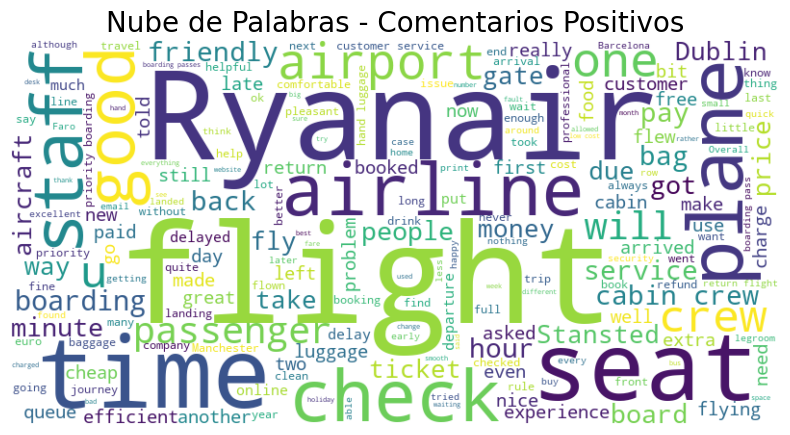

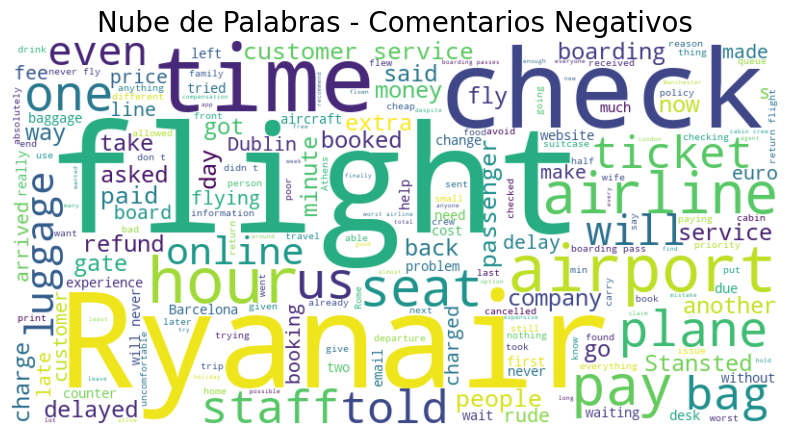

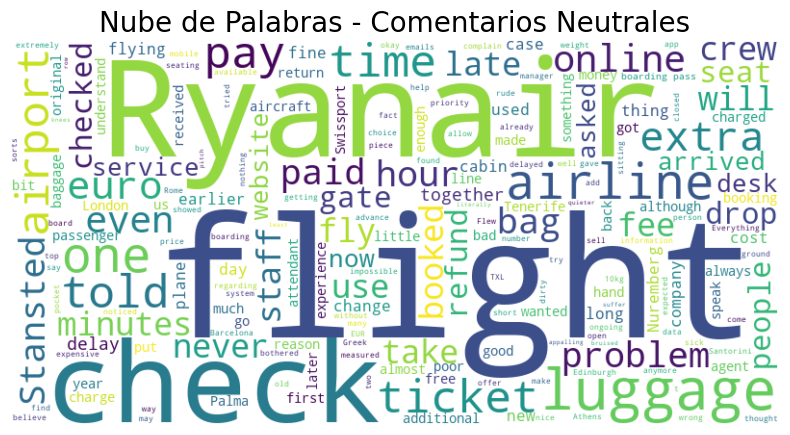

In [65]:
from wordcloud import WordCloud

# Convertir a DataFrame de Pandas para usar Matplotlib y Seaborn
df_comments = dataset.select("Comment", "sentiment").toPandas()

# Filtrar comentarios por sentimiento
positive_comments = " ".join(df_comments[df_comments['sentiment'] == 'positive']['Comment'].astype(str).tolist())
negative_comments = " ".join(df_comments[df_comments['sentiment'] == 'negative']['Comment'].astype(str).tolist())
neutral_comments = " ".join(df_comments[df_comments['sentiment'] == 'neutral']['Comment'].astype(str).tolist())

# Crear nubes de palabras
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, size=20)
    plt.axis('off')
    plt.show()

# Nube de palabras para comentarios positivos
create_wordcloud(positive_comments, 'Nube de Palabras - Comentarios Positivos')

# Nube de palabras para comentarios negativos
create_wordcloud(negative_comments, 'Nube de Palabras - Comentarios Negativos')

# Nube de palabras para comentarios neutrales
create_wordcloud(neutral_comments, 'Nube de Palabras - Comentarios Neutrales')


#### Distribución de Sentimientos

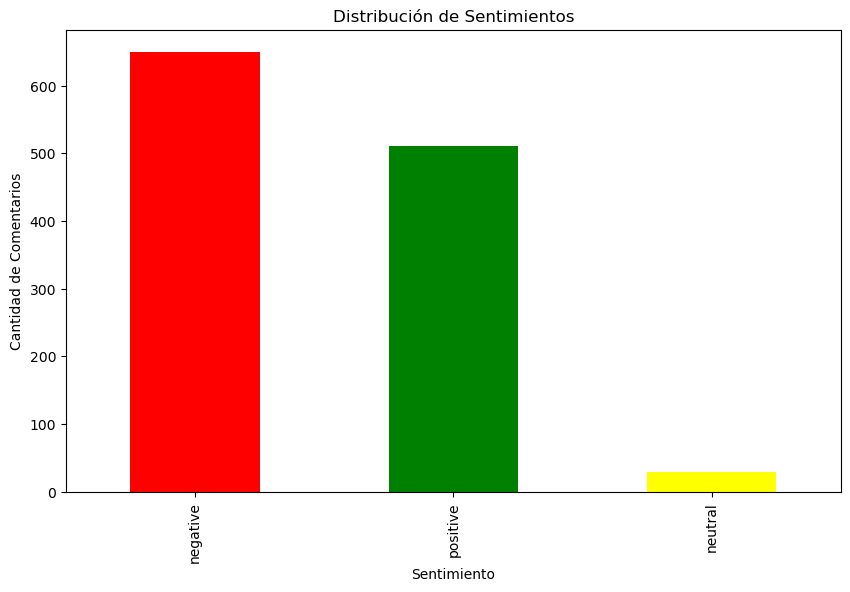

In [26]:
# Asegúrate de tener los datos en un DataFrame de Pandas para usar Matplotlib
df = dataset.toPandas()

# Distribución de Sentimientos
plt.figure(figsize=(10, 6))
df['sentiment'].value_counts().plot(kind='bar', color=['red', 'green', 'yellow'])
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Comentarios')
plt.show()


#### Sentimientos por Tipo de Viajero

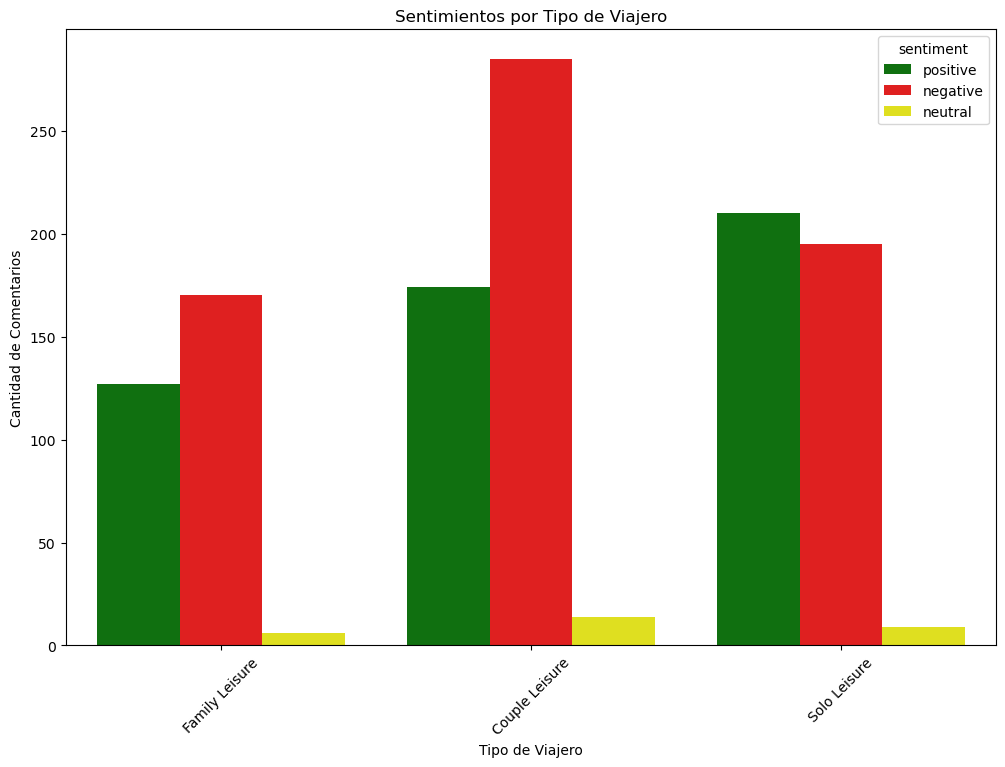

In [27]:
df = dataset.select("Type Of Traveller", "sentiment").toPandas()

plt.figure(figsize=(12, 8))
sns.countplot(x='Type Of Traveller', hue='sentiment', data=df, palette=['green', 'red', 'yellow'])
plt.title('Sentimientos por Tipo de Viajero')
plt.xlabel('Tipo de Viajero')
plt.ylabel('Cantidad de Comentarios')
plt.xticks(rotation=45)
plt.show()



#### Sentimientos por Clase de Servicio

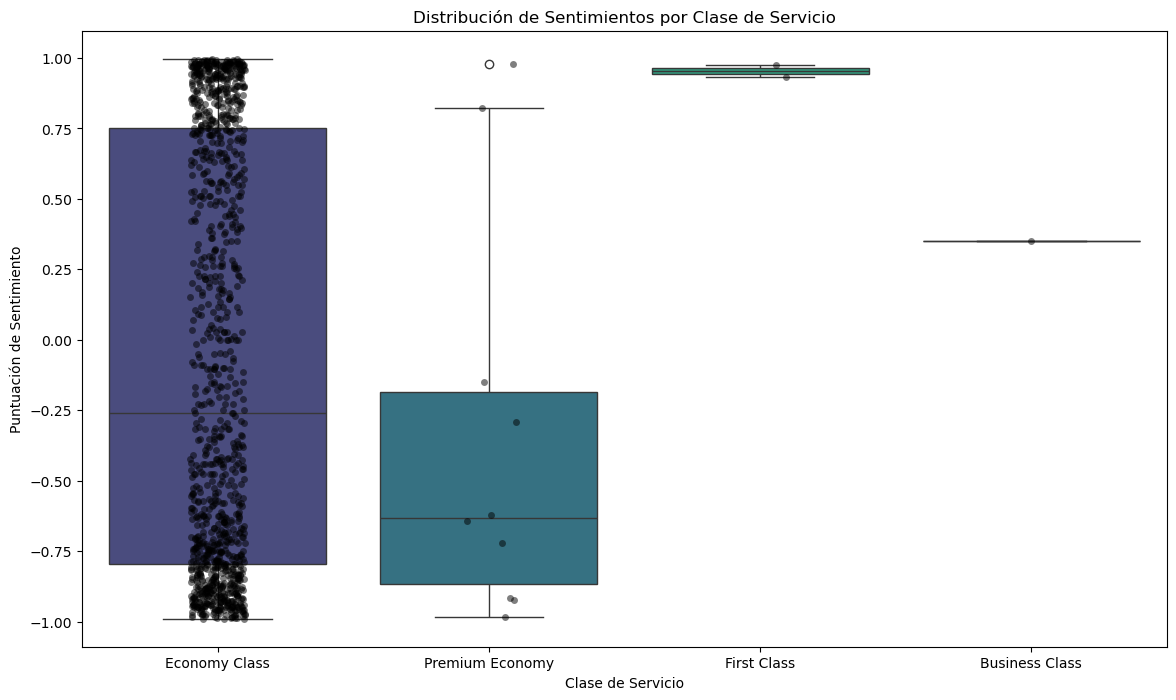

In [68]:
# Convertir a DataFrame de Pandas para usar Matplotlib y Seaborn
df = dataset.select("sentiment_score", "Seat Type").toPandas()

# Asegurarse de que los valores son numéricos
df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')

# Crear gráfico de boxplot con jitter
plt.figure(figsize=(14, 8))
sns.boxplot(x='Seat Type', y='sentiment_score', hue='Seat Type', data=df, palette='viridis', dodge=False)
sns.stripplot(x='Seat Type', y='sentiment_score', data=df, color='black', alpha=0.5, jitter=True, dodge=False)
plt.title('Distribución de Sentimientos por Clase de Servicio')
plt.xlabel('Clase de Servicio')
plt.ylabel('Puntuación de Sentimiento')
plt.legend([],[], frameon=False)  # Ocultar la leyenda redundante
plt.show()


#### Correlación entre Sentimientos y Valoraciones

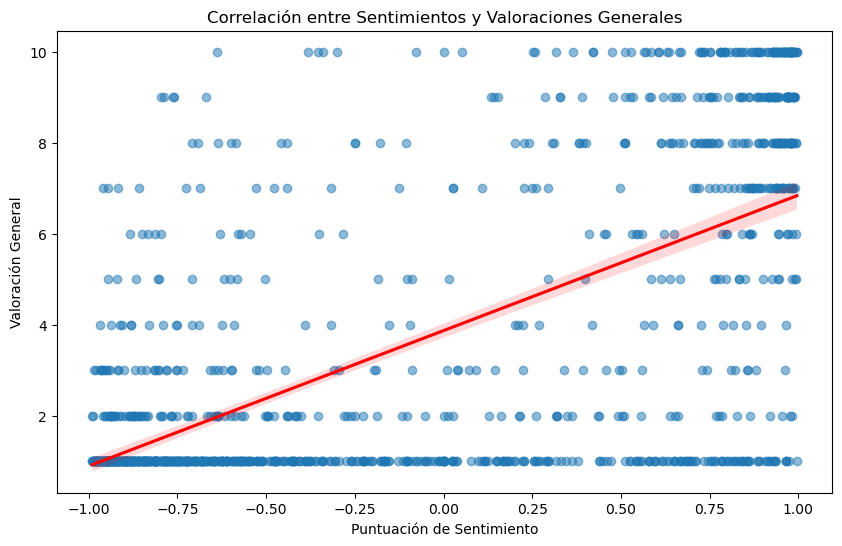

In [30]:
# Definir y convertir a DataFrame de Pandas
df_sentiment_score = dataset.select("sentiment_score", "Overall Rating").toPandas()

# Convertir las columnas a tipo numérico si no lo son
df_sentiment_score['sentiment_score'] = pd.to_numeric(df_sentiment_score['sentiment_score'], errors='coerce')
df_sentiment_score['Overall Rating'] = pd.to_numeric(df_sentiment_score['Overall Rating'], errors='coerce')

# Paso 2: Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.regplot(x='sentiment_score', y='Overall Rating', data=df_sentiment_score, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
plt.title('Correlación entre Sentimientos y Valoraciones Generales')
plt.xlabel('Puntuación de Sentimiento')
plt.ylabel('Valoración General')
plt.show()




### Análisis de Varianza (ANOVA)
Usaremos ANOVA para determinar si las diferencias en los sentimientos son estadísticamente significativas entre diferentes grupos.

In [32]:
from pyspark.sql.functions import col

# Asegurarse de que la columna 'sentiment_score' está en formato numérico
dataset = dataset.withColumn("sentiment_score", col("sentiment_score").cast("float"))

# Calcular la correlación entre el puntaje de sentimientos y las variables numéricas
numeric_columns = ['Overall Rating', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Value For Money']
for column in numeric_columns:
    correlation = dataset.stat.corr('sentiment_score', column)
    print(f"Correlation between sentiment_score and {column}: {correlation}")

# Ejecutar ANOVA para cada variable categórica
anova_results = {}
for column in ["Overall Rating", "Type Of Traveller", "Seat Type"]:
    anova_data = dataset.select(column, "sentiment_score")
    pandas_df = anova_data.toPandas()
    groups = [pandas_df[pandas_df[column] == val]["sentiment_score"].dropna() for val in pandas_df[column].unique()]
    anova_results[column] = stats.f_oneway(*groups)

# Mostrar los resultados del ANOVA
for column, result in anova_results.items():
    print(f"ANOVA result for {column}: F={result.statistic}, p-value={result.pvalue}")



Correlation between sentiment_score and Overall Rating: 0.6537098206488229
Correlation between sentiment_score and Seat Comfort: 0.46641779263793187
Correlation between sentiment_score and Cabin Staff Service: 0.5465088615909955
Correlation between sentiment_score and Food & Beverages: 0.40095227246767523
Correlation between sentiment_score and Ground Service: 0.5768188262585976
Correlation between sentiment_score and Value For Money: 0.6228901673332747
ANOVA result for Overall Rating: F=100.46377886633262, p-value=4.087288180229986e-139
ANOVA result for Type Of Traveller: F=7.639939958406461, p-value=0.000504882594799101
ANOVA result for Seat Type: F=2.122828392725131, p-value=0.09559650766716829


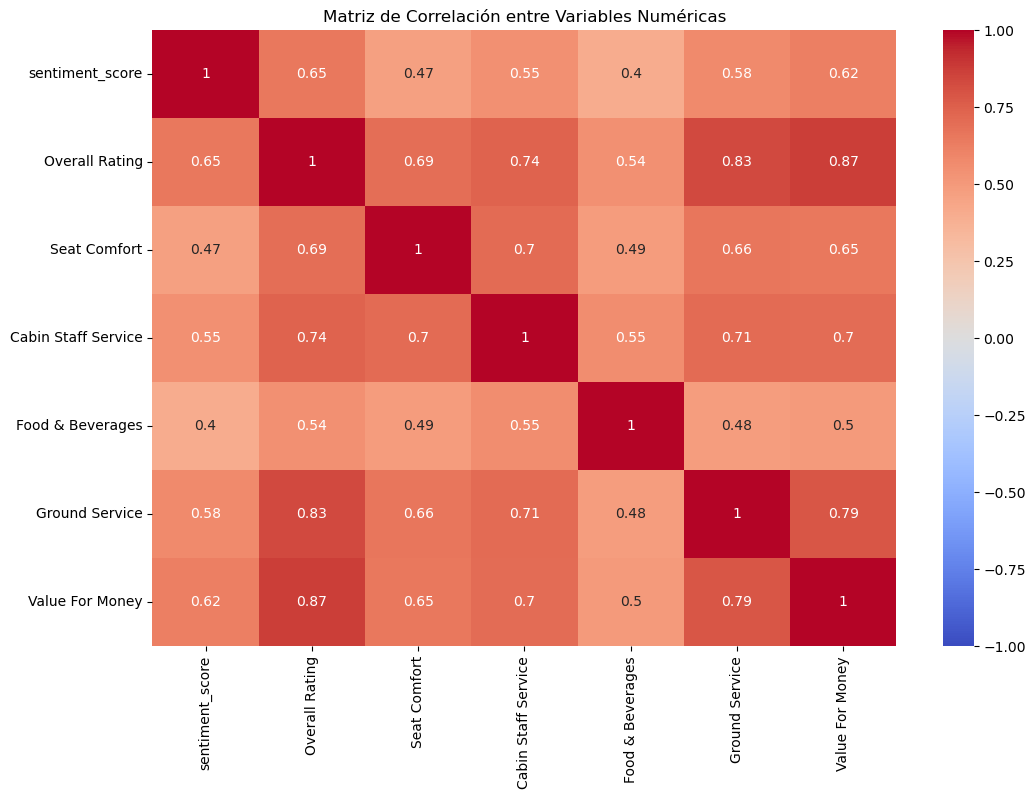

In [33]:
# Graficar la Matriz de Correlación 

# Convertir a DataFrame de Pandas para usar Matplotlib y Seaborn
df_corr = dataset.select(["sentiment_score", "Overall Rating", "Seat Comfort", "Cabin Staff Service", "Food & Beverages", "Ground Service", "Value For Money"]).toPandas()

# Calcular la matriz de correlación
corr_matrix = df_corr.corr()

# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()


### Algoritmos de Aprendizaje Automático


In [34]:
from pyspark.sql.functions import col, when

# Convertir la columna 'Recommended' a tipo binario si no se ha hecho ya
dataset = dataset.withColumn('Recommended', when(col('Recommended') == 'yes', 1).when(col('Recommended') == 'no', 0).otherwise(col('Recommended').cast('int')))


In [35]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_data, test_data = dataset.randomSplit([0.8, 0.2], seed=42)

# Modelos de Aprendizaje Automático
lr = LogisticRegression(featuresCol="scaled_features", labelCol="Recommended")
nb = NaiveBayes(featuresCol="scaled_features", labelCol="Recommended")
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="Recommended", numTrees=100)

# Evaluadores para diferentes métricas
evaluators = {
    "accuracy": MulticlassClassificationEvaluator(labelCol="Recommended", predictionCol="prediction", metricName="accuracy"),
    "precision": MulticlassClassificationEvaluator(labelCol="Recommended", predictionCol="prediction", metricName="weightedPrecision"),
    "recall": MulticlassClassificationEvaluator(labelCol="Recommended", predictionCol="prediction", metricName="weightedRecall"),
    "f1": MulticlassClassificationEvaluator(labelCol="Recommended", predictionCol="prediction", metricName="f1")
}

# Función para entrenar y evaluar modelos
def train_and_evaluate(model, train_data, test_data, evaluators):
    model_fit = model.fit(train_data)
    train_predictions = model_fit.transform(train_data)
    test_predictions = model_fit.transform(test_data)
    train_results = {metric: evaluator.evaluate(train_predictions) for metric, evaluator in evaluators.items()}
    test_results = {metric: evaluator.evaluate(test_predictions) for metric, evaluator in evaluators.items()}
    return train_results, test_results

# Evaluar modelos
results_dict = {"train": {}, "test": {}}--

modeling_stages = [lr, nb, rf]

for model in modeling_stages:
    train_results, test_results = train_and_evaluate(model, train_data, test_data, evaluators)
    results_dict["train"][model.__class__.__name__] = train_results
    results_dict["test"][model.__class__.__name__] = test_results
    print(f"Train Results for {model.__class__.__name__}: {train_results}")
    print(f"Test Results for {model.__class__.__name__}: {test_results}")

# Convertir los resultados a un DataFrame de Pandas
train_results_df = pd.DataFrame(results_dict["train"]).T
test_results_df = pd.DataFrame(results_dict["test"]).T




Train Results for LogisticRegression: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Test Results for LogisticRegression: {'accuracy': 0.8557692307692307, 'precision': 0.8538948366231738, 'recall': 0.8557692307692308, 'f1': 0.8544745484400655}
Train Results for NaiveBayes: {'accuracy': 0.984725050916497, 'precision': 0.9848413571534583, 'recall': 0.9847250509164969, 'f1': 0.9847546264137204}
Test Results for NaiveBayes: {'accuracy': 0.8509615384615384, 'precision': 0.850368923611111, 'recall': 0.8509615384615385, 'f1': 0.8506435188936607}
Train Results for RandomForestClassifier: {'accuracy': 0.7352342158859471, 'precision': 0.8101407489323602, 'recall': 0.7352342158859471, 'f1': 0.6678765290614207}
Test Results for RandomForestClassifier: {'accuracy': 0.7067307692307693, 'precision': 0.7944240196078431, 'recall': 0.7067307692307693, 'f1': 0.602874535354801}


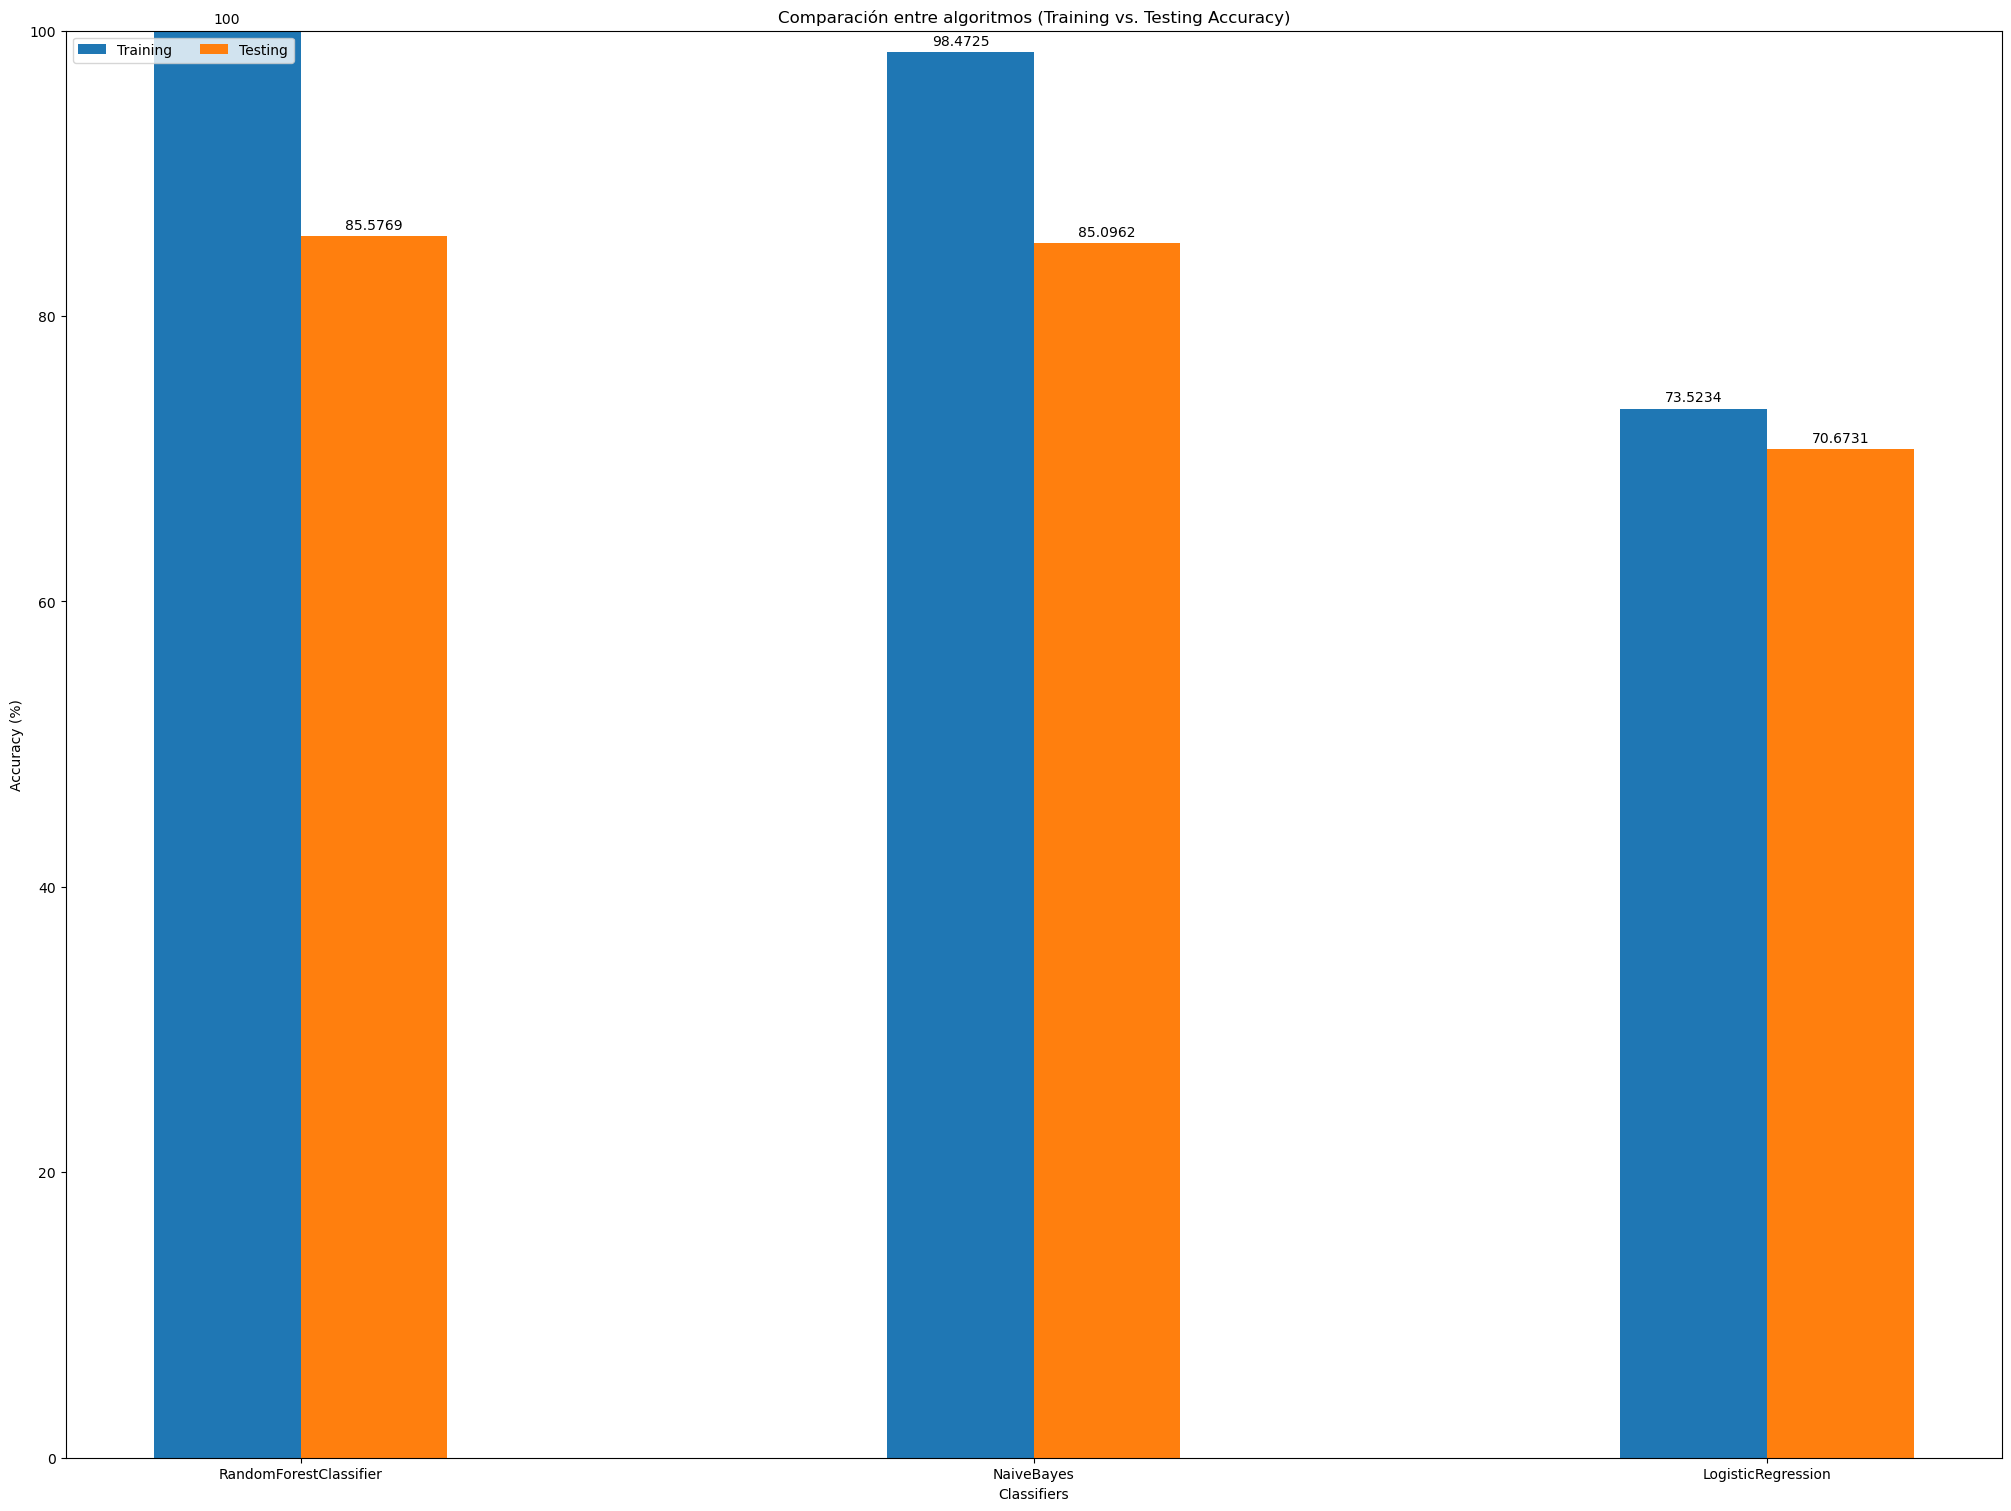

In [69]:
# Extraer solo los resultados de accuracy
train_accuracy_df = train_results_df[['accuracy']]
test_accuracy_df = test_results_df[['accuracy']]

# Crear el gráfico combinado
classifiers = ["RandomForestClassifier", "NaiveBayes", "LogisticRegression"]
train_accuracies = train_accuracy_df['accuracy'].values * 100
test_accuracies = test_accuracy_df['accuracy'].values * 100

data = {
    'Training': train_accuracies,
    'Testing': test_accuracies
}

x = np.arange(len(classifiers))  
width = 0.20  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(20, 15), constrained_layout=True)

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Añadir etiquetas
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Classifiers')
ax.set_title('Comparación entre algoritmos (Training vs. Testing Accuracy)')
ax.set_xticks(x + width / 2, classifiers)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 100)

plt.show()